# Brazilian Cities Analysis for HDI Prediction

This notebook aims to analyse a extra tree regressor model to predict the Human Development Index (HDI) of Brazilian cities. The dataset used in this notebook is the Brazilian Cities Dataset, which contains information about the HDI and other features of Brazilian cities.

Data Source: https://www.kaggle.com/crisparada/brazilian-cities
- All the data is in the data directory of the repository.

## Dataset Aquisition and Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Remove the limiter on the number of columns displayed
pd.set_option('display.max_columns', None)

# Load the data
df = pd.read_csv('data/BRAZIL_CITIES_REV2022.csv')
df.head()

,CITY,STATE,CAPITAL,IBGE_RES_POP,IBGE_RES_POP_BRAS,IBGE_RES_POP_ESTR,IBGE_DU,IBGE_DU_URBAN,IBGE_DU_RURAL,IBGE_POP,IBGE_1,IBGE_1-4,IBGE_5-9,IBGE_10-14,IBGE_15-59,IBGE_60+,IBGE_PLANTED_AREA,IBGE_CROP_PRODUCTION_$,IDHM Ranking 2010,IDHM,IDHM_Renda,IDHM_Longevidade,IDHM_Educacao,LONG,LAT,ALT,PAY_TV,FIXED_PHONES,AREA,REGIAO_TUR,CATEGORIA_TUR,ESTIMATED_POP,RURAL_URBAN,GVA_AGROPEC,GVA_INDUSTRY,GVA_SERVICES,GVA_PUBLIC,GVA_TOTAL,TAXES,GDP,POP_GDP,GDP_CAPITA,GVA_MAIN,MUN_EXPENDIT,COMP_TOT,COMP_A,COMP_B,COMP_C,COMP_D,COMP_E,COMP_F,COMP_G,COMP_H,COMP_I,COMP_J,COMP_K,COMP_L,COMP_M,COMP_N,COMP_O,COMP_P,COMP_Q,COMP_R,COMP_S,COMP_T,COMP_U,HOTELS,BEDS,Pr_Agencies,Pu_Agencies,Pr_Bank,Pu_Bank,Pr_Assets,Pu_Assets,Cars,Motorcycles,Wheeled_tractor,UBER,MAC,WAL-MART,POST_OFFICES
0,Abadia De Goiás,GO,0,6876,6876,0,2137,1546,591,5300,69,318,438,517,3542,416,319,1843,1689,0.708,0.687,0.830,0.622,-49.4405,-16.7588,893.6015,360,842,147.256,0,0,8583,Urbano,6201,27991,74750,36915,145858,20554,166412,8053,20665.0,Demais serviços,28227690,284,5,1,56,0,2,29,110,26,4,5,0,2,10,12,4,6,6,1,5,0,0,0,0,0,0,0,0,0,0,2158,1246,0,0,0,0,1
1,Abadia Dos Dourados,MG,0,6704,6704,0,2328,1481,847,4154,38,207,260,351,2709,589,4479,18017,2207,0.689,0.693,0.839,0.563,-47.3968,-18.4876,753.1249,77,296,881.064,Caminhos Do Cerrado,D,6972,Rural Adjacente,50525,25918,62689,28084,167215,12873,180089,7037,25592.0,Demais serviços,17909274,476,6,6,30,1,2,34,190,70,28,11,0,4,15,29,2,9,14,6,19,0,0,0,0,0,0,0,0,0,0,2227,1142,0,0,0,0,1
2,Abadiânia,GO,0,15757,15609,148,4655,3233,1422,10656,139,650,894,1087,6896,990,10307,33085,2202,0.689,0.671,0.841,0.579,-48.7188,-16.1827,1017.5506,227,720,1045.127,Região Turística Do Ouro E Cristais,C,19614,Rural Adjacente,42839,16728,138199,63396,261162,26823,287984,18427,15628.0,Demais serviços,37513019,288,5,9,26,0,2,7,117,12,57,2,1,0,7,15,3,11,5,1,8,0,0,1,34,1,1,1,1,33724584,67091904,2838,1426,0,0,0,0,3
3,Abaetetuba,PA,0,141100,141040,60,31061,19057,12004,82956,1354,5567,7618,8905,53516,5996,25200,700872,3530,0.628,0.579,0.798,0.537,-48.8844,-1.7235,10.1203,3389,1218,1610.651,Araguaia-Tocantins,D,156292,Urbano,140464,58610,468129,486872,1154075,95180,1249255,151934,8222.0,"Administração, defesa, educação e saúde públic...",0,931,4,2,43,0,1,27,500,16,31,6,1,1,22,16,2,155,33,15,56,0,0,0,0,2,4,2,4,76181384,800078483,5277,25661,0,0,0,0,2
4,Abaeté,MG,0,22690,22690,0,7694,6667,1027,18464,176,856,1233,1539,11979,2681,1862,7502,1994,0.698,0.720,0.848,0.556,-45.4462,-19.1558,644.7399,1230,1716,1817.067,Lago De Três Marias,D,23223,Urbano,113825,31003,172333,86081,403241,26994,430235,23574,18250.0,Demais serviços,0,621,18,1,40,0,1,20,303,62,30,9,6,4,28,27,2,15,19,9,27,0,0,0,0,2,2,2,2,44974716,371922572,6928,2953,0,0,0,0,4


In [2]:
# Droping IDHM high correlated columns CITY column
df = df.drop(columns=['IDHM Ranking 2010', 'IDHM_Renda', 'IDHM_Longevidade', 'IDHM_Educacao', 'CITY'])

nonCategoricalColumns = ['STATE', 'REGIAO_TUR', 'CATEGORIA_TUR', 'RURAL_URBAN', 'GVA_MAIN']

# Changing non categorical columns into categorical (0, 1...)
for column in nonCategoricalColumns:
    df[column] = pd.Categorical(df[column])
    df[column] = df[column].cat.codes

# Split the data into features and target
X = df.drop(columns=['IDHM'], axis=1)
y = df['IDHM']

# check for nan values
print(df.isnull().sum().sum())

df.head()

0


,STATE,CAPITAL,IBGE_RES_POP,IBGE_RES_POP_BRAS,IBGE_RES_POP_ESTR,IBGE_DU,IBGE_DU_URBAN,IBGE_DU_RURAL,IBGE_POP,IBGE_1,IBGE_1-4,IBGE_5-9,IBGE_10-14,IBGE_15-59,IBGE_60+,IBGE_PLANTED_AREA,IBGE_CROP_PRODUCTION_$,IDHM,LONG,LAT,ALT,PAY_TV,FIXED_PHONES,AREA,REGIAO_TUR,CATEGORIA_TUR,ESTIMATED_POP,RURAL_URBAN,GVA_AGROPEC,GVA_INDUSTRY,GVA_SERVICES,GVA_PUBLIC,GVA_TOTAL,TAXES,GDP,POP_GDP,GDP_CAPITA,GVA_MAIN,MUN_EXPENDIT,COMP_TOT,COMP_A,COMP_B,COMP_C,COMP_D,COMP_E,COMP_F,COMP_G,COMP_H,COMP_I,COMP_J,COMP_K,COMP_L,COMP_M,COMP_N,COMP_O,COMP_P,COMP_Q,COMP_R,COMP_S,COMP_T,COMP_U,HOTELS,BEDS,Pr_Agencies,Pu_Agencies,Pr_Bank,Pu_Bank,Pr_Assets,Pu_Assets,Cars,Motorcycles,Wheeled_tractor,UBER,MAC,WAL-MART,POST_OFFICES
0,8,0,6876,6876,0,2137,1546,591,5300,69,318,438,517,3542,416,319,1843,0.708,-49.4405,-16.7588,893.6015,360,842,147.256,0,0,8583,6,6201,27991,74750,36915,145858,20554,166412,8053,20665.0,5,28227690,284,5,1,56,0,2,29,110,26,4,5,0,2,10,12,4,6,6,1,5,0,0,0,0,0,0,0,0,0,0,2158,1246,0,0,0,0,1
1,10,0,6704,6704,0,2328,1481,847,4154,38,207,260,351,2709,589,4479,18017,0.689,-47.3968,-18.4876,753.1249,77,296,881.064,37,4,6972,3,50525,25918,62689,28084,167215,12873,180089,7037,25592.0,5,17909274,476,6,6,30,1,2,34,190,70,28,11,0,4,15,29,2,9,14,6,19,0,0,0,0,0,0,0,0,0,0,2227,1142,0,0,0,0,1
2,8,0,15757,15609,148,4655,3233,1422,10656,139,650,894,1087,6896,990,10307,33085,0.689,-48.7188,-16.1827,1017.5506,227,720,1045.127,215,3,19614,3,42839,16728,138199,63396,261162,26823,287984,18427,15628.0,5,37513019,288,5,9,26,0,2,7,117,12,57,2,1,0,7,15,3,11,5,1,8,0,0,1,34,1,1,1,1,33724584,67091904,2838,1426,0,0,0,0,3
3,13,0,141100,141040,60,31061,19057,12004,82956,1354,5567,7618,8905,53516,5996,25200,700872,0.628,-48.8844,-1.7235,10.1203,3389,1218,1610.651,11,4,156292,6,140464,58610,468129,486872,1154075,95180,1249255,151934,8222.0,1,0,931,4,2,43,0,1,27,500,16,31,6,1,1,22,16,2,155,33,15,56,0,0,0,0,2,4,2,4,76181384,800078483,5277,25661,0,0,0,0,2
4,10,0,22690,22690,0,7694,6667,1027,18464,176,856,1233,1539,11979,2681,1862,7502,0.698,-45.4462,-19.1558,644.7399,1230,1716,1817.067,125,4,23223,6,113825,31003,172333,86081,403241,26994,430235,23574,18250.0,5,0,621,18,1,40,0,1,20,303,62,30,9,6,4,28,27,2,15,19,9,27,0,0,0,0,2,2,2,2,44974716,371922572,6928,2953,0,0,0,0,4


In [3]:
# Copy a new dataset without outliers
df_copy = df.copy()

for column in df.columns:
    # Calculate the quartiles
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Filter the outliers
    df_copy = df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]

In [4]:
from re import X
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.corr()

idhm_correlation = correlation_matrix['IDHM']

correlation_threshold = 0.1

# Identifies columns that have a low correlation with IDHM
low_correlation_columns = idhm_correlation[abs(idhm_correlation) < correlation_threshold].index.tolist()

data_cleaned = df.drop(columns=low_correlation_columns)

X = data_cleaned.drop(columns=['IDHM'], axis=1)
y = data_cleaned['IDHM']

print("Removed columns due to low correlation with IDHM:", low_correlation_columns)

Removed columns due to low correlation with IDHM: ['CAPITAL', 'IBGE_RES_POP_ESTR', 'COMP_D', 'COMP_J', 'COMP_K', 'COMP_U', 'Pr_Assets', 'Pu_Assets']


## Appying the GridSearchCV algorithm to Decision Tree Regressor

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import numpy as np

# KFold with shuffle
kfold = KFold(n_splits=7, shuffle=True, random_state=42)
tree = ExtraTreesRegressor(random_state=42)

# GridSearchCV params
param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [30, 50],
    'min_samples_split': [10, 20]
}

# R2 scores for plotting
scores = []

# Method for training the model with 4 possible different configurations
def apply_model(apply_pca=False, remove_outliers_flag=False):
    # Use df_copy if removing outliers, otherwise use df
    data = df_copy if remove_outliers_flag else df

    X = data.drop(columns=['IDHM'], axis=1)
    y = data['IDHM']

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Applying PCA if necessary
    if apply_pca:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        pca = PCA(n_components=0.95)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)
        X_train, X_test = X_train_pca, X_test_pca

    # GridSearchCV for testing param_grid values
    grid_search = GridSearchCV(tree, param_grid, cv=kfold, scoring='r2', verbose=3)
    grid_search.fit(X_train, y_train)

    # Best model and predictions
    best_tree = grid_search.best_estimator_
    y_pred = best_tree.predict(X_test)

    # R2 score
    r2_score = grid_search.score(X_test, y_test)
    scores.append(r2_score)

    print(f"\nModel {'with' if apply_pca else 'without'} PCA and {'removing' if remove_outliers_flag else 'maintaining'} outliers:")
    print(f"Best params: {grid_search.best_params_}")
    print(f"R²: {r2_score}")

# Applying model without PCA and removing outliers
apply_model(apply_pca=False, remove_outliers_flag=True)

# Applying model without PCA and maintaining outliers
apply_model(apply_pca=False, remove_outliers_flag=False)

# Applying model with PCA and removing outliers
apply_model(apply_pca=True, remove_outliers_flag=True)

# Applying model with PCA and maintaining outliers
apply_model(apply_pca=True, remove_outliers_flag=False)

# Printing the best R² score
print(f"\nBest R² score: {max(scores)}")

Fitting 7 folds for each of 8 candidates, totalling 56 fits
[CV 1/7] END max_depth=30, min_samples_split=10, n_estimators=300;, score=0.865 total time=   8.8s
[CV 2/7] END max_depth=30, min_samples_split=10, n_estimators=300;, score=0.841 total time=   8.7s
[CV 3/7] END max_depth=30, min_samples_split=10, n_estimators=300;, score=0.875 total time=   8.3s
[CV 4/7] END max_depth=30, min_samples_split=10, n_estimators=300;, score=0.814 total time=   8.6s
[CV 5/7] END max_depth=30, min_samples_split=10, n_estimators=300;, score=0.876 total time=   7.7s
[CV 6/7] END max_depth=30, min_samples_split=10, n_estimators=300;, score=0.855 total time=   8.1s
[CV 7/7] END max_depth=30, min_samples_split=10, n_estimators=300;, score=0.806 total time=   7.3s
[CV 1/7] END max_depth=30, min_samples_split=10, n_estimators=500;, score=0.866 total time=  13.9s
[CV 2/7] END max_depth=30, min_samples_split=10, n_estimators=500;, score=0.841 total time=  12.6s
[CV 3/7] END max_depth=30, min_samples_split=10, 

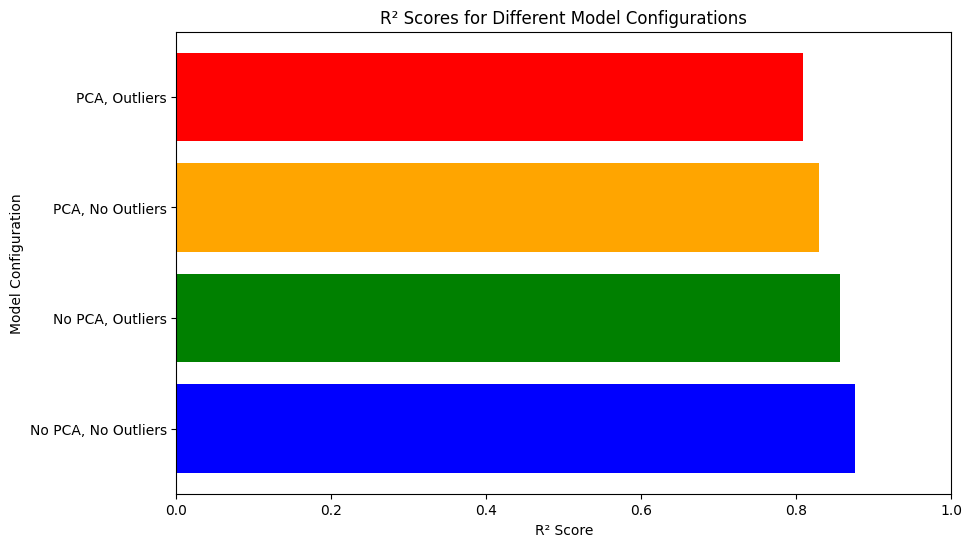

In [6]:
# Plotting R² and training configurations
labels = ['No PCA, No Outliers', 'No PCA, Outliers', 'PCA, No Outliers', 'PCA, Outliers']
plt.figure(figsize=(10, 6))
plt.barh(labels, scores, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('R² Score')
plt.ylabel('Model Configuration')
plt.title('R² Scores for Different Model Configurations')
plt.xlim(0, 1)
plt.show()

## Conclusion

Training the model without PCA and removing outliers was the combination that produced the best results, with an R² value of 0.875, suggesting that the model benefits from more information (all columns) and a database without outliers. The configuration with 500 estimators, a max depth of 30, and a minimum of 10 samples per split yielded a more robust and generalizable model. These hyperparameters allowed the ExtraTrees algorithm to effectively capture complex relationships in the data, leading to improved predictive performance. The results demonstrate that eliminating PCA preserved valuable variance, while outlier removal helped the model focus on the main distribution of the data, contributing to its enhanced accuracy.